# **SNA Major Project : Travel Plannig using Social network graph**
> A user-centric approach to cost-effective and interest-based travel recommendations

- Submitted by Yash Parmar

In [ ]:
#@title Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title Import libraries

import pandas as pd
import random
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from itertools import permutations
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [ ]:
#@title loading our dataset

def load_data():
    user_to_city = pd.read_csv('/content/drive/My Drive/colab/SNA Project/temp/users_to_cities.csv')
    city_to_city = pd.read_csv('/content/drive/My Drive/colab/SNA Project/temp/cities_connections.csv')
    user_to_user = pd.read_csv('/content/drive/My Drive/colab/SNA Project/temp/users_connections.csv')

    # for giant dataset
    # user_to_city = pd.read_csv('/content/drive/My Drive/colab/SNA Project/giant_users_to_cities.csv')
    # city_to_city = pd.read_csv('/content/drive/My Drive/colab/SNA Project/giant_cities_connections.csv')
    # user_to_user = pd.read_csv('/content/drive/My Drive/colab/SNA Project/giant_users_connections.csv')

    return user_to_city, city_to_city, user_to_user

In [ ]:
#@title Build our social networking graph

def build_graphs(user_to_city, city_to_city, user_to_user):
    G_cities = nx.MultiGraph()
    for _, row in city_to_city.iterrows():
        G_cities.add_edge(row['city1'], row['city2'], mode=row['mode'], time=row['time'], cost=row['cost'])

    G_simple = nx.Graph()
    for u, v, data in G_cities.edges(data=True):
        cost, time = data['cost'], data['time']
        if G_simple.has_edge(u, v):
            if cost < G_simple[u][v]['cost']:
                G_simple[u][v]['cost'] = cost
                G_simple[u][v]['time'] = time
        else:
            G_simple.add_edge(u, v, cost=cost, time=time)

    G_users = nx.Graph()
    for _, row in user_to_user.iterrows():
        u, v, city = row['to_user'], row['from_user'], row['shared_city']
        if G_users.has_edge(u, v):
            G_users.edges[u, v]['shared_cities'].add(city)
        else:
            G_users.add_edge(u, v, shared_cities={city})

    return G_cities, G_simple, G_users


In [ ]:
#@title function for return visited city

def get_visited_cities(user_to_city):
    visited = defaultdict(set)
    for _, row in user_to_city.iterrows():
        if row['status'] in ['Visited', 'Reviewed']:
            visited[row['user']].add(row['city'])
    return visited

In [ ]:
#@title Function for check if shared city is valid or not (It is Valid, if shared city is either visited or reviewed)

def get_shared_cities_with_validation(user, G_users, visited_cities):
    valid_shared_cities = set()
    if user not in G_users.nodes:
        return valid_shared_cities
    for neighbor in G_users.neighbors(user):
        shared = G_users.edges[user, neighbor]['shared_cities']
        for city in shared:
            if city in visited_cities.get(neighbor, set()):
                valid_shared_cities.add(city)
    return valid_shared_cities

## **Function that finds optimal journey path :**

- Fastest path ( low time)
- Cheapest path (low cost)

In [ ]:
def find_optimal_path(G, source, target, weight):
    try:
        path = nx.shortest_path(G, source, target, weight=weight)
        total = nx.shortest_path_length(G, source, target, weight=weight)
        return path, total
    except nx.NetworkXNoPath:
        return None, float('inf')

In [ ]:
def calculate_path_time(G, path):
    total_time = 0
    for i in range(len(path) - 1):
        edge_data = G.get_edge_data(path[i], path[i + 1])
        best_edge = min(edge_data.values(), key=lambda x: x['cost'])
        total_time += best_edge['time']
    return total_time

### **Function that check valid path based on connection that have shared city**

> If shared city has not been visited or reviewed by the user who recommended then it will not considered.

In [ ]:
def find_valid_paths(source, destination, G_cities, shared_cities):
    from itertools import permutations, product

    valid_paths = set()
    results = []

    shared_cities = [c for c in shared_cities if c != destination]
    if not shared_cities:
        for weight in ['cost', 'time']:
            path, total = find_optimal_path(G_cities, source, destination, weight=weight)
            if path:
                total_time = calculate_path_time(G_cities, path)
                total_cost = sum(min(data['cost'] for data in G_cities.get_edge_data(path[i], path[i+1]).values())
                                 for i in range(len(path)-1))
                results.append({'path': path, 'time': total_time, 'cost': total_cost})
        return results

    all_combos = []
    for r in range(1, len(shared_cities)+1):
        all_combos.extend(permutations(shared_cities, r))

    for perm in all_combos:
        full_seq = [source] + list(perm) + [destination]

        # Now generate all combinations of (time-optimal, cost-optimal) for each segment
        segment_paths_options = []

        for i in range(len(full_seq)-1):
            u, v = full_seq[i], full_seq[i+1]
            segment_opts = []

            for weight in ['cost', 'time']:
                path, _ = find_optimal_path(G_cities, u, v, weight=weight)
                if path:
                    segment_opts.append(path)

            if not segment_opts:
                break  # can't proceed
            segment_paths_options.append(segment_opts)

        # Now create cartesian product of all segments to get full paths
        for path_combo in product(*segment_paths_options):
            full_path = [path_combo[0][0]]
            for segment in path_combo:
                full_path += segment[1:]
            if len(set(full_path)) == len(full_path):  # no loops
                path_key = tuple(full_path)
                if path_key not in valid_paths:
                    total_time = calculate_path_time(G_cities, full_path)
                    total_cost = sum(min(data['cost'] for data in G_cities.get_edge_data(full_path[i], full_path[i+1]).values())
                                     for i in range(len(full_path)-1))
                    results.append({'path': full_path, 'time': total_time, 'cost': total_cost})
                    valid_paths.add(path_key)

    return results


### **Function to calculate Similarity between the users**

In [ ]:
def compute_jaccard_similarity(user1, user2, visited_cities):
    set1 = visited_cities.get(user1, set())
    set2 = visited_cities.get(user2, set())
    if not set1 or not set2:
        return 0.0
    intersection = set1 & set2
    union = set1 | set2
    return len(intersection) / len(union)

In [ ]:
def compute_network_measures(G_users, visited_cities):

    print("------------------------------------------------------------------------------------------")
    print("\n📊 Network Similarity and Centrality Measures:")
    eigen_centrality = nx.eigenvector_centrality(G_users)
    betweenness_centrality = nx.betweenness_centrality(G_users)

    for user in G_users.nodes():
        print(f"\nUser {user}:")
        print(f"  Eigenvector Centrality: {eigen_centrality[user]:.3f}")
        print(f"  Betweenness Centrality: {betweenness_centrality[user]:.3f}")

        no_sim_found = True
        for neighbor in G_users.nodes():
            if user != neighbor:
                sim = compute_jaccard_similarity(user, neighbor, visited_cities)
                if sim > 0:
                    print(f"  Jaccard Similarity with {neighbor}: {sim:.3f}")
                    no_sim_found = False
        if no_sim_found:
            print(f"  ❌ No Jaccard similarity with any other user.")

In [ ]:
import community as community_louvain
import matplotlib.pyplot as plt

def detect_communities(G_users):

    print("------------------------------------------------------------------------------------------")
    print("\n🔍 Detecting Communities using Louvain Method...")

    if len(G_users.nodes) == 0:
        print("❌ Cannot detect communities. Graph is empty.")
        return

    # Compute communities
    partition = community_louvain.best_partition(G_users)

    # Group users by their community
    community_dict = {}
    for user, comm_id in partition.items():
        community_dict.setdefault(comm_id, []).append(user)

    # Display communities
    print(f"\n🧭 Total Communities Found: {len(community_dict)}")
    for comm_id, members in community_dict.items():
        print(f"Community {comm_id + 1}: {members}")

    # (Optional) Visualize
    pos = nx.spring_layout(G_users)
    cmap = plt.get_cmap('viridis')
    plt.figure(figsize=(8, 6))
    nx.draw(G_users, pos, node_color=list(partition.values()), with_labels=True, cmap=cmap, node_size=500)
    plt.title("User Communities (Louvain Detection)")
    plt.show()


### **Main Driver Function**

Enter source city: City_1
Enter destination city: City_6
Enter your user ID: User_6
------------------------------------------------------------------------------------------

Finding travel paths from City_1 to City_6 for User_6...

✅ Valid shared cities from your network: {'City_5'}

✅ All Valid Travel Paths:

Path 1: City_1 → City_4 → City_5 → City_8 → City_6
  Total Time: 25 hours
  Total Cost: ₹4451

Path 2: City_1 → City_5 → City_8 → City_6
  Total Time: 16 hours
  Total Cost: ₹7253

Path 3: City_1 → City_4 → City_5 → City_6
  Total Time: 13 hours
  Total Cost: ₹8169

Path 4: City_1 → City_5 → City_6
  Total Time: 4 hours
  Total Cost: ₹10971
------------------------------------------------------------------------------------------

⭐ Optimal Recommendations:

Fastest Path (4 hours): City_1 → City_5 → City_6
  Cost: ₹10971

Cheapest Path (₹4451): City_1 → City_4 → City_5 → City_8 → City_6
  Time: 25 hours
---------------------------------------------------------------------------

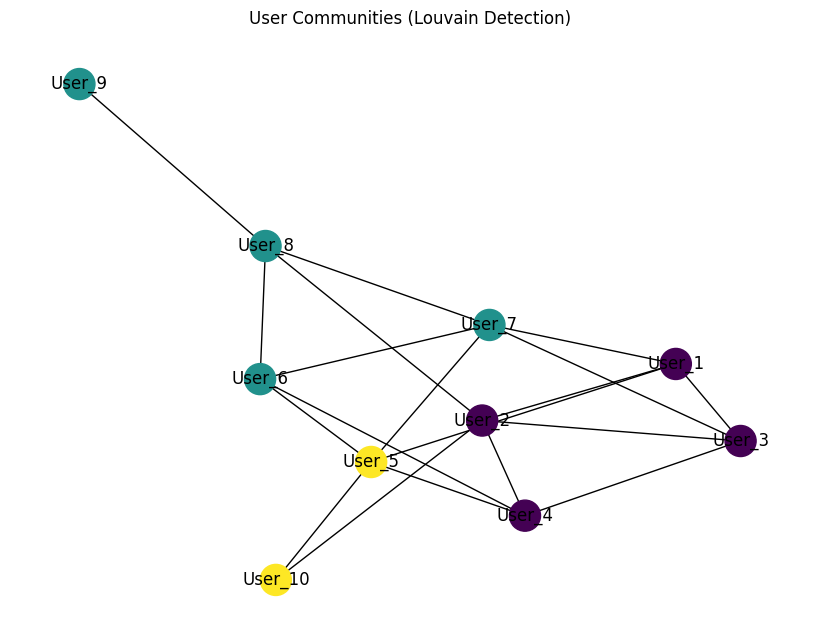

In [ ]:
def recommend_travel_paths():
    user_to_city, city_to_city, user_to_user = load_data()
    G_cities, G_simple, G_users = build_graphs(user_to_city, city_to_city, user_to_user)
    visited_cities = get_visited_cities(user_to_city)

    source = input("Enter source city: ").strip()
    destination = input("Enter destination city: ").strip()
    user = input("Enter your user ID: ").strip()

    print("------------------------------------------------------------------------------------------")
    print(f"\nFinding travel paths from {source} to {destination} for {user}...")

    shared_cities = get_shared_cities_with_validation(user, G_users, visited_cities)
    print(f"\n✅ Valid shared cities from your network: {shared_cities}")

    valid_paths = find_valid_paths(source, destination, G_cities, shared_cities)

    if not valid_paths:
        print("\n❌ No valid travel paths found considering your network.")
        return

    valid_paths.sort(key=lambda x: (x['cost'], x['time']))

    print("\n✅ All Valid Travel Paths:")
    for i, path in enumerate(valid_paths, 1):
        print(f"\nPath {i}: {' → '.join(path['path'])}")
        print(f"  Total Time: {path['time']} hours")
        print(f"  Total Cost: ₹{path['cost']}")

    fastest = min(valid_paths, key=lambda x: x['time'])
    cheapest = min(valid_paths, key=lambda x: x['cost'])

    print("------------------------------------------------------------------------------------------")

    print("\n⭐ Optimal Recommendations:")
    print(f"\nFastest Path ({fastest['time']} hours): {' → '.join(fastest['path'])}")
    print(f"  Cost: ₹{fastest['cost']}")
    print(f"\nCheapest Path (₹{cheapest['cost']}): {' → '.join(cheapest['path'])}")
    print(f"  Time: {cheapest['time']} hours")

    compute_network_measures(G_users, visited_cities)
    detect_communities(G_users)

if __name__ == "__main__":
    recommend_travel_paths()

### **Function for predicting city that User most probably visit :**

> Here Prediction based on the connection that mostly visited or reviewe.

In [ ]:
import pandas as pd
from collections import Counter

# Load the CSVs
df_users_to_cities, df_city_to_city, df_user_connections = load_data()

# Get all unique users
all_users = df_users_to_cities['user'].unique()

# Build a dictionary: user -> visited cities
user_cities = df_users_to_cities.groupby('user')['city'].apply(set).to_dict()

# Build a dictionary: user -> connected users
user_connections = {}
for _, row in df_user_connections.iterrows():
    from_user = row['from_user'].strip()
    to_user = row['to_user'].strip()

    if from_user not in user_connections:
        user_connections[from_user] = set()
    if to_user not in user_connections:
        user_connections[to_user] = set()

    user_connections[from_user].add(to_user)
    user_connections[to_user].add(from_user)


In [ ]:
# Predict next city for a specific user
def predict_next_city(user_id):
    print(f"\n📌 Predicting next city for: {user_id}")

    visited = user_cities.get(user_id, set())
    connected_users = user_connections.get(user_id, set())

    if not connected_users:
        print("❌ No connected users found.")
        return

    # Gather all cities visited by connected users
    recommended = []
    for conn_user in connected_users:
        cities = user_cities.get(conn_user, set())
        new_cities = cities - visited
        recommended.extend(new_cities)

    if not recommended:
        print("❌ No new cities to recommend based on connected users.")
        return

    # Count frequency of each potential city
    city_counts = Counter(recommended)
    most_common = city_counts.most_common(1)[0]

    print(f"✅ Most probable next city: {most_common[0]} (visited {most_common[1]} times by connections)")

# Run prediction for user
user = input("To predict user next visiting place, Enter the User ID: ").strip()
predict_next_city(user)


To predict user next visiting place, Enter the User ID: User_6

📌 Predicting next city for: User_6
✅ Most probable next city: City_5 (visited 2 times by connections)
